In [ ]:
from keras.datasets import mnist
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import accuracy_score
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight


np.random.seed(123)

class MNISTClassificationBaseModel(ABC):

  class_count = 10
  original_dataset_shape = (28, 28)
  classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

  @abstractmethod
  def __init__(self, balanced=False, noise_type='No Noise', noise_ratio=0):
    (self._x_train, self._y_train), (self._x_test, self._y_test) = mnist.load_data()
    self._original_dataset = (np.copy(self._x_train), np.copy(self._y_train),
                              np.copy(self._x_test), np.copy(self._y_test))

    if balanced is True:
      self.balance_dataset()

    self.shape_data()

    if noise_type == 'asym':
      self.induce_asym_noise(noise_ratio)
      clean_selected = np.argwhere(self.get_training_label() == self.get_original_dataset()[1]).reshape((-1,))
      noisy_selected = np.argwhere(self.get_training_label() != self.get_original_dataset()[1]).reshape((-1,))
      print("#correct labels: %s, #incorrect labels: %s" % (len(clean_selected), len(noisy_selected)))
    elif noise_type == 'sym':
      self.induce_sym_noise(noise_ratio)
      clean_selected = np.argwhere(self.get_training_label() == self.get_original_dataset()[1]).reshape((-1,))
      noisy_selected = np.argwhere(self.get_training_label() != self.get_original_dataset()[1]).reshape((-1,))
      print("#correct labels: %s, #incorrect labels: %s" % (len(clean_selected), len(noisy_selected)))
    elif noise_type == 'No Noise':
      pass
    else:
      raise ValueError('%s noise type is not recognized. Value can be asym, sym or No Noise' % noise_type)

  def get_original_dataset(self):
    return self._original_dataset;

  def get_training_image(self):
    return self._x_train

  def get_training_label(self):
    return self._y_train

  def get_test_image(self):
    return self._x_test

  def get_test_label(self):
    return self._y_test

  def scale_pixels(self):
    # Convert from integers to float
    self._x_train = self._x_train.astype('float32')
    self._x_test = self._x_test.astype('float32')

    # Normalize pixels from range [0, 255] to [0, 1]
    self._x_train /= 255.0
    self._x_test /= 255.0

  def show_class_distribution(self, original_dataset=False):
    if original_dataset:
      unique, counts = np.unique(self.get_original_dataset()[1], return_counts=True)
      plt.bar(unique, counts)
      # unique, counts = np.unique(self.get_original_dataset()[3], return_counts=True)
      # plt.bar(unique, counts)
    else:
      unique, counts = np.unique(self.get_training_label(), return_counts=True)
      plt.bar(unique, counts)
      # unique, counts = np.unique(self.get_test_label(), return_counts=True)
      # plt.bar(unique, counts)

    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.show()

  def print_accuracy(self, predicted):
    print('Accuracy for the predicted labels : ' , accuracy_score(self.get_test_label(), predicted) * 100)

  def display_confusion_matrix(self, predicted):
    cm = metrics.confusion_matrix(self.get_test_label(), predicted,
                                  labels=MNISTClassificationBaseModel.classes)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=MNISTClassificationBaseModel.classes)
    disp.plot()
    plt.show()

  def display_samples(self, images, actual_labels, predicted_labels, is_label_pre_processed):

    images = images.reshape(*self.get_model_shape())
    predicted_labels = predicted_labels.squeeze()
    actual_labels = actual_labels.squeeze()

    l = len(images)

    while True:
      if l <= 0:
        break

      cols = min(5, l)

      subset_images, images = np.asarray(images[:cols]), np.asarray(images[cols:])
      subset_predicted_labels, predicted_labels = np.asarray(predicted_labels[:cols]), np.asarray(predicted_labels[cols:])
      subset_actual_labels, actual_labels = np.asarray(actual_labels[:cols]), np.asarray(actual_labels[cols:])

      _, axes = plt.subplots(nrows=1, ncols=cols, figsize=(10, 3),
                          constrained_layout=True)

      for ax, image, actual_label, predicted_label in zip(axes, subset_images, subset_actual_labels, subset_predicted_labels):
        ax.set_axis_off()
        ax.imshow(image.reshape(MNISTClassificationBaseModel.original_dataset_shape), cmap='gray')
        if is_label_pre_processed:
          ax.set_title('Actual: %i, Predicted: %i' % (np.argmax(actual_label), np.argmax(predicted_label)))
        else:
          ax.set_title('Actual: %i, Predicted: %i' % (actual_label, predicted_label))

      plt.show()

      l -=cols

  def _get_misclassified_indices(self, predicted):
    return np.nonzero(predicted != self.get_test_label())

  def get_misclassified(self, predicted):
    misclassified_indices = np.asarray(self._get_misclassified_indices(predicted))
    misclassified_test_image = self.get_test_image()[misclassified_indices]
    misclassified_predicted_label = predicted[misclassified_indices]
    misclassified_actual_label = self.get_test_label()[misclassified_indices]
    return misclassified_test_image, misclassified_actual_label, misclassified_predicted_label

  def balance_dataset(self):
    rus = RandomUnderSampler(random_state=123)
    self._x_train = self._x_train.reshape(-1, 28 * 28)
    self._x_train, self._y_train = rus.fit_resample(self.get_training_image(), self.get_training_label())
    self._x_train = self._x_train.reshape(-1, 28, 28)

  def induce_asym_noise(self, noise_ratio=40):
    source_class = [7, 2, 3, 5, 6]
    target_class = [1, 7, 8, 6, 5]
    y_train_clean = np.copy(self.get_training_label())

    for s, t in zip(source_class, target_class):
      cls_idx = np.where(y_train_clean == s)[0]
      # print('cls_idx',cls_idx)
      n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
      # print('n_noisy',n_noisy)
      noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
      # print(noisy_sample_index)
      self._y_train[noisy_sample_index] = t

    print("Print noisy label generation statistics:")
    for i in range(MNISTClassificationBaseModel.class_count):
      n_noisy = np.sum(self.get_training_label() == i)
      print("Noisy class %s, has %s samples." % (i, n_noisy))

  def other_class(self, n_classes, current_class):
    if current_class < 0 or current_class >= n_classes:
        error_str = "class_ind must be within the range (0, nb_classes - 1)"
        raise ValueError(error_str)

    other_class_list = list(range(n_classes))
    other_class_list.remove(current_class)
    other_class = np.random.choice(other_class_list)
    return other_class

  def induce_sym_noise(self, noise_ratio=40):
    y_train_clean = np.copy(self.get_training_label())
    n_samples = self.get_training_label().shape[0]
    n_noisy = int(noise_ratio * n_samples / 100)
    # print(n_samples, n_noisy)
    class_index = [np.where(y_train_clean == i)[0] for i in range(MNISTClassificationBaseModel.class_count)]
    class_noisy = int(n_noisy / 10)

    noisy_idx = []
    for d in range(MNISTClassificationBaseModel.class_count):
      noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
      noisy_idx.extend(noisy_class_index)

    for i in noisy_idx:
      self._y_train[i] = self.other_class(n_classes=MNISTClassificationBaseModel.class_count,
                                     current_class=self.get_training_label()[i])

  @abstractmethod
  def shape_data(self):
    pass

  @abstractmethod
  def get_model_shape(self):
    pass

  @abstractmethod
  def pre_process_label(self):
    pass

  @abstractmethod
  def _define_model(self):
    pass

In [ ]:
from tensorflow import keras 

import tensorflow as tf 
import numpy as np 
# from PatternRecognition import *

In [ ]:
class LDAMLoss():

    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = tf.convert_to_tensor(m_list, dtype=tf.float32)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight
        self.n_classes = len(cls_num_list)

    def __call__(self, target, x):
        index_float = target
        batch_m = tf.matmul(self.m_list[None, :], tf.transpose(index_float))
        batch_m = tf.reshape(batch_m, (-1, 1))
        x_m = x - batch_m

        index_bool = tf.cast(index_float, tf.bool)
        output = tf.where(index_bool, x_m, x)

        labels = index_float
        logits = output
        
        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits*self.s)
        return tf.reduce_mean(loss)

In [ ]:
class LDAM(MNISTClassificationBaseModel):

  def __init__(self, balanced=False, noise_type='No Noise', noise_ratio=0):
    super().__init__(balanced, noise_type, noise_ratio)

  def get_model_shape(self):
    return SVMModel.shape

  def shape_data(self):
    # expand new axis, channel axis 
    self._x_train = np.expand_dims(self._x_train, axis=-1)
    self._x_test = np.expand_dims(self._x_test, axis=-1)

    # [optional]: we may need 3 channel (instead of 1)
    self._x_train = np.repeat(self._x_train, 3, axis=-1)
    self._x_test = np.repeat(self._x_test, 3, axis=-1)

    self._x_train = self._x_train.astype('float32') / 255
    self._x_test = self._x_test.astype('float32') / 255

    self._x_train = tf.image.resize(self._x_train, [32,32])
    self._x_test = tf.image.resize(self._x_test, [32,32])

  def pre_process_label(self):
    self._y_train = tf.keras.utils.to_categorical(self._y_train , num_classes=10)
    self._y_test = tf.keras.utils.to_categorical(self._y_test , num_classes=10)

  def display_confusion_matrix(self, predicted):
    cm = metrics.confusion_matrix(np.argmax(self.get_test_label(), axis=1), predicted,
                                  labels=MNISTClassificationBaseModel.classes)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=MNISTClassificationBaseModel.classes)
    disp.plot()
    plt.show()

  def print_accuracy(self, predicted):
    print('Accuracy for the predicted labels : ' , accuracy_score(np.argmax(self.get_test_label(), axis=1), predicted) * 100)

  def _define_model(self):
    input = tf.keras.Input(shape=(32,32,3))
    efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

    # bind all
    func_model = tf.keras.Model(efnet.input, output)
    return func_model

  def balance_dataset(self):
    rus = RandomUnderSampler(random_state=123)
    self._x_train = self._x_train.reshape(-1, 28 * 28)
    print(self._x_train.shape)
    self._x_train, self._y_train = rus.fit_resample(self.get_training_image(), self.get_training_label())
    self._x_train = self._x_train.reshape(-1, 28, 28)
    print(self._x_train.shape)

  def train_and_predict(self):

    epochs = 5
    unique, counts = np.unique(self.get_original_dataset()[1], return_counts=True)

    cls_num_list = []
    for i in counts:
      cls_num_list.append(i)

    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(np.argmax(self.get_training_label(), axis=1)),
                                                 y=np.argmax(self.get_training_label(), axis=1))

    class_weight_dict = {}
    for idx, i in enumerate(np.ndenumerate(class_weight)):
      print(idx, i)
      class_weight_dict[idx] = i

    model = self._define_model()
    model.compile(
          loss  = LDAMLoss(cls_num_list),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
    # fit 
    model.fit(self._x_train, self._y_train, batch_size=64, epochs=5, verbose = 2)
    predicted = model.predict(self.get_test_image())
    return model, predicted

#correct labels: 36000, #incorrect labels: 24000
0 ((), <module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>)
Epoch 1/5
938/938 - 109s - loss: 16.4364 - categorical_accuracy: 0.3703 - 109s/epoch - 116ms/step
Epoch 2/5
938/938 - 101s - loss: 16.3299 - categorical_accuracy: 0.3232 - 101s/epoch - 107ms/step
Epoch 3/5
938/938 - 100s - loss: 15.5320 - categorical_accuracy: 0.4437 - 100s/epoch - 107ms/step
Epoch 4/5
938/938 - 100s - loss: 15.2822 - categorical_accuracy: 0.4949 - 100s/epoch - 107ms/step
Epoch 5/5
938/938 - 100s - loss: 14.4456 - categorical_accuracy: 0.5489 - 100s/epoch - 107ms/step


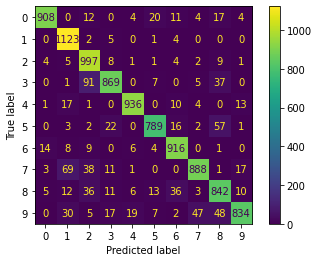

Accuracy for the predicted labels :  91.02


In [ ]:
l = LDAM(balanced=False, noise_type='sym', noise_ratio=40)
l.pre_process_label()
model, predicted = l.train_and_predict()
l.display_confusion_matrix(np.argmax(predicted, axis=1))
l.print_accuracy(np.argmax(predicted, axis=1))

Print noisy label generation statistics:
Noisy class 0, has 5923 samples.
Noisy class 1, has 9248 samples.
Noisy class 2, has 3575 samples.
Noisy class 3, has 3679 samples.
Noisy class 4, has 5842 samples.
Noisy class 5, has 5620 samples.
Noisy class 6, has 5719 samples.
Noisy class 7, has 6142 samples.
Noisy class 8, has 8303 samples.
Noisy class 9, has 5949 samples.
#correct labels: 48124, #incorrect labels: 11876
Epoch 1/5
938/938 - 109s - loss: 7.7243 - categorical_accuracy: 0.7531 - 109s/epoch - 116ms/step
Epoch 2/5
938/938 - 103s - loss: 7.0725 - categorical_accuracy: 0.7743 - 103s/epoch - 109ms/step
Epoch 3/5
938/938 - 103s - loss: 6.5636 - categorical_accuracy: 0.7881 - 103s/epoch - 109ms/step
Epoch 4/5
938/938 - 103s - loss: 6.5258 - categorical_accuracy: 0.7882 - 103s/epoch - 109ms/step
Epoch 5/5
938/938 - 102s - loss: 6.4447 - categorical_accuracy: 0.7896 - 102s/epoch - 109ms/step


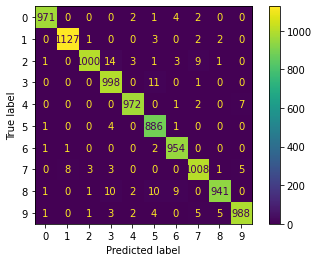

Accuracy for the predicted labels :  98.45


In [ ]:
l1 = LDAM(balanced=False, noise_type='asym', noise_ratio=40)
l1.pre_process_label()
model, predicted = l1.train_and_predict()
l1.display_confusion_matrix(np.argmax(predicted, axis=1))
l1.print_accuracy(np.argmax(predicted, axis=1))

Epoch 1/5
938/938 - 109s - loss: 1.8135 - categorical_accuracy: 0.9496 - 109s/epoch - 116ms/step
Epoch 2/5
938/938 - 102s - loss: 0.8122 - categorical_accuracy: 0.9780 - 102s/epoch - 108ms/step
Epoch 3/5
938/938 - 102s - loss: 0.7347 - categorical_accuracy: 0.9800 - 102s/epoch - 109ms/step
Epoch 4/5
938/938 - 102s - loss: 0.7361 - categorical_accuracy: 0.9801 - 102s/epoch - 109ms/step
Epoch 5/5
938/938 - 102s - loss: 1.1315 - categorical_accuracy: 0.9699 - 102s/epoch - 109ms/step


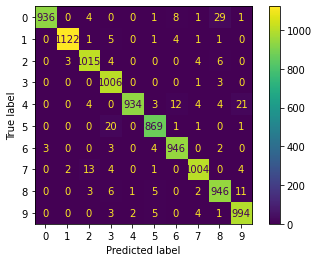

Accuracy for the predicted labels :  97.72


In [ ]:
l2 = LDAM(balanced=False, noise_type='No Noise', noise_ratio=40)
l2.pre_process_label()
model, predicted = l2.train_and_predict()
l2.display_confusion_matrix(np.argmax(predicted, axis=1))
l2.print_accuracy(np.argmax(predicted, axis=1))

(60000, 784)
(54210, 28, 28)
(54210, 32, 32, 3)
(54210, 10)
(60000, 28, 28)
0 ((), <module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>)
Epoch 1/5
848/848 - 99s - loss: 1.8356 - categorical_accuracy: 0.9468 - 99s/epoch - 117ms/step
Epoch 2/5
848/848 - 91s - loss: 1.8310 - categorical_accuracy: 0.9482 - 91s/epoch - 108ms/step
Epoch 3/5
848/848 - 92s - loss: 1.2310 - categorical_accuracy: 0.9652 - 92s/epoch - 108ms/step
Epoch 4/5
848/848 - 92s - loss: 0.7181 - categorical_accuracy: 0.9798 - 92s/epoch - 108ms/step
Epoch 5/5
848/848 - 91s - loss: 0.5071 - categorical_accuracy: 0.9861 - 91s/epoch - 108ms/step


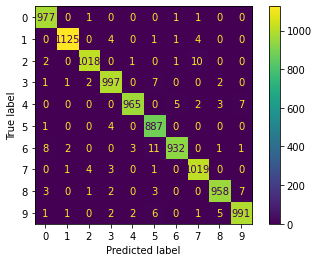

Accuracy for the predicted labels :  98.69


In [ ]:
l3 = LDAM(balanced=True, noise_type='No Noise', noise_ratio=0)
l3.pre_process_label()
print(l3.get_training_image().shape)
print(l3.get_training_label().shape)
print(l3.get_original_dataset()[0].shape)

model, predicted = l3.train_and_predict()
l3.display_confusion_matrix(np.argmax(predicted, axis=1))
l3.print_accuracy(np.argmax(predicted, axis=1))

(60000, 784)
(54210, 28, 28)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


#correct labels: 0, #incorrect labels: 0
0 ((), <module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>)
94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/5
848/848 - 109s - loss: 16.8221 - categorical_accuracy: 0.2244 - 109s/epoch - 128ms/step
Epoch 2/5
848/848 - 91s - loss: 17.3139 - categorical_accuracy: 0.1023 - 91s/epoch - 107ms/step
Epoch 3/5
848/848 - 91s - loss: 17.0402 - categorical_accuracy: 0.1236 - 91s/epoch - 107ms/step
Epoch 4/5
848/848 - 91s - loss: 16.9782 - categorical_accuracy: 0.1491 - 91s/epoch - 107ms/step
Epoch 5/5
848/848 - 92s - loss: 16.7647 - categorical_accuracy: 0.1410 - 92s/epoch - 108ms/step


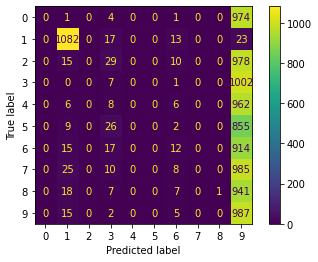

Accuracy for the predicted labels :  20.89


In [ ]:
l4 = LDAM(balanced=True, noise_type='sym', noise_ratio=40)
l4.pre_process_label()
model, predicted = l4.train_and_predict()
l4.display_confusion_matrix(np.argmax(predicted, axis=1))
l4.print_accuracy(np.argmax(predicted, axis=1))

In [1]:
l5 = LDAM(balanced=True, noise_type='asym', noise_ratio=40)
l5.pre_process_label()
model, predicted = l5.train_and_predict()
l5.display_confusion_matrix(np.argmax(predicted, axis=1))
l5.print_accuracy(np.argmax(predicted, axis=1))

NameError: ignored